Epoch 1/1000
57/57 [==============================] - 2s 5ms/step - loss: 0.0224
Epoch 2/1000
57/57 [==============================] - 0s 5ms/step - loss: 5.8723e-04
Epoch 3/1000
57/57 [==============================] - 0s 4ms/step - loss: 4.1981e-04
Epoch 4/1000
57/57 [==============================] - 0s 3ms/step - loss: 3.8107e-04
Epoch 5/1000
57/57 [==============================] - 0s 4ms/step - loss: 3.5841e-04
Epoch 6/1000
57/57 [==============================] - 0s 3ms/step - loss: 3.4461e-04
Epoch 7/1000
57/57 [==============================] - 0s 3ms/step - loss: 3.4538e-04
Epoch 8/1000
57/57 [==============================] - 0s 4ms/step - loss: 3.0056e-04
Epoch 9/1000
57/57 [==============================] - 0s 5ms/step - loss: 3.0881e-04
Epoch 10/1000
57/57 [==============================] - 0s 4ms/step - loss: 3.3238e-04
Epoch 11/1000
57/57 [==============================] - 0s 2ms/step - loss: 3.0840e-04
Epoch 12/1000
57/57 [==============================] - 0s 2ms/step 

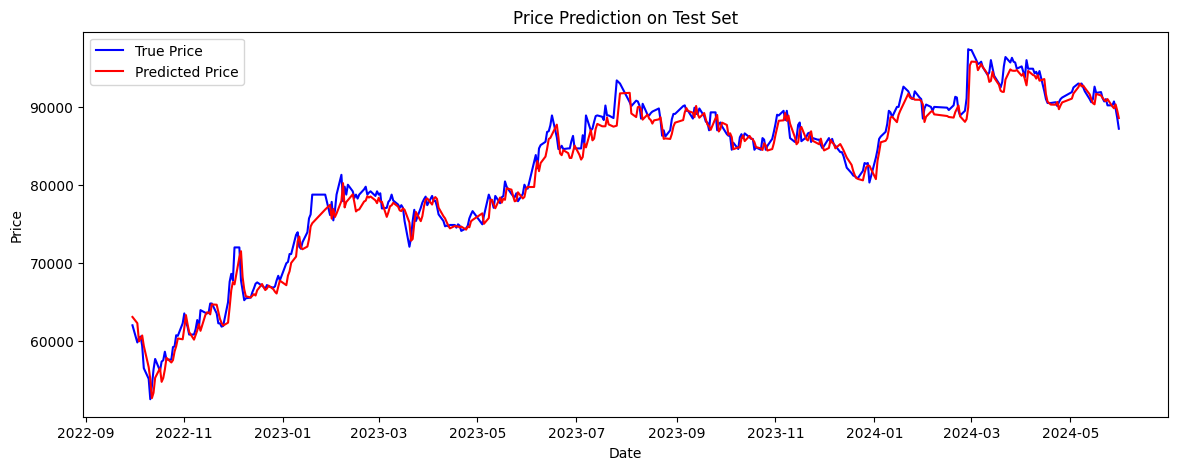

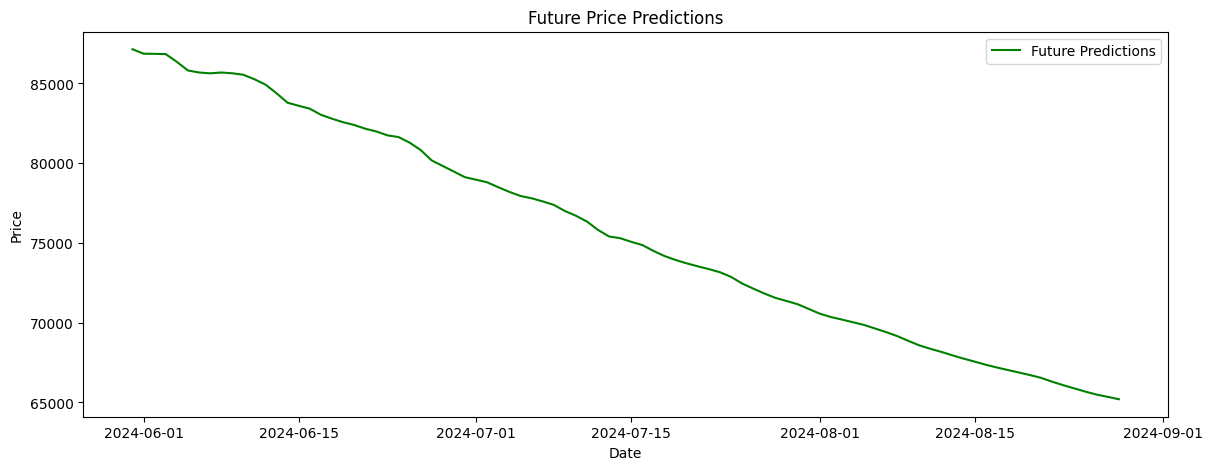

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Nadam

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('/VCB (1).csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=1000, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(df.index[-len(Y_test):], Y_test, color='blue', label='True Price')
plt.plot(df.index[-len(Y_test):], Y_pred_test, color='red', label='Predicted Price')
plt.title('Price Prediction on Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(pd.date_range(df.index[-1], periods=90, freq='D'), future_predictions, color='green', label='Future Predictions')
plt.title('Future Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

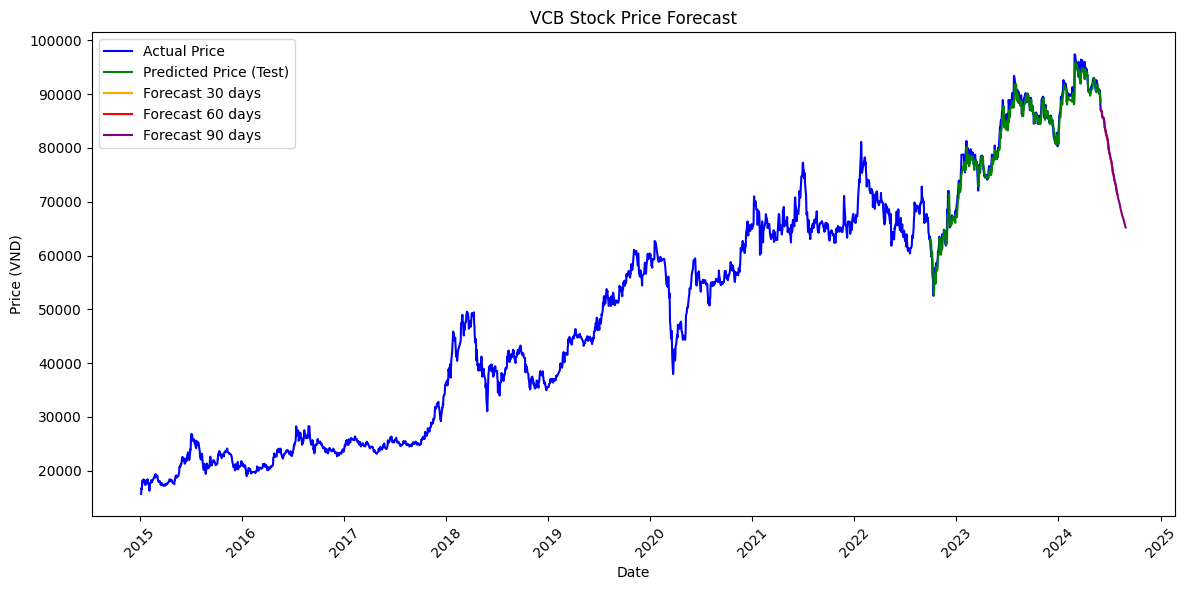

In [6]:
# Trực quan hóa
plt.figure(figsize=(12, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predicted Price (Test)', color='green')

# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Forecast 30 days', color='orange')
plt.plot(future_dates[:60], future_predictions[:60], label='Forecast 60 days', color='red')
plt.plot(future_dates, future_predictions, label='Forecast 90 days', color='purple')

plt.title('VCB Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu VCB trong 90 ngày tới:")
print(future_df)

Dự báo giá cổ phiếu VCB trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  87145.429688
2024-06-02  86864.218750
2024-06-03  86855.375000
2024-06-04  86839.429688
2024-06-05  86355.007812
...                  ...
2024-08-25  65879.695312
2024-08-26  65677.906250
2024-08-27  65493.574219
2024-08-28  65352.324219
2024-08-29  65204.441406

[90 rows x 1 columns]


In [8]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 1419.8508601364642
MAPE: 1.3548900265385733 %
MDA: 1078.8302983302692
